<a href="https://colab.research.google.com/github/bhaskarayh/IHSG-forecasting-using-LSTM/blob/main/Peramalan_IHSG_Menggunakan_Algoritma_LSTM_v1_6_7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melakukan Peramalan dengan menggunakan model LSTM

Model LSTM (Long Short Term Memory) merupakan Deep Neural Network yang mampu melakukan peramalan pergerakan saham ataupun jenis peramalan lainnya. Untuk menggunakan model ini, ada beberapa hal yang harus diperlukan, yaitu :
1. Membuat data generator <br/>Sebelum membuat data generator, data harus dibersihkan dan dilakukan Pre-processing
2. Menentukan hyperparameter yang tepat untuk meminimalisir nilai Error
3. Melakukan visualisasi dan evaluasi

Peramalan Harga Penutupan Saham dari IHSG menggunakan data saham 50 hari sebelumnya

# Membersihkan Data dan melakukan Pre-Processing

## Library yang digunakan <br/>
Tahap awal adalah menentukan dan mendownload library yang akan digunakan. Di bawah ini adalah library - library yang akan digunakan dalam penelitian ini

In [ ]:
# import library yang dibutuhkan
# import math untuk melakukan perhitungan
import math

# Import pandas_datareader untuk mengambil data dari Yahoo Finance
from pandas_datareader import data as pdr

# Numpy untuk formatting number atau array
import numpy as np

# Pandas untuk membuat DataFrame dan membaca dokumen CSV
import pandas as pd

# Sklearn sebagai komponen machine learning, untuk penskalaan, membagi dataset dan menghitung nilai error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Tensorflow dan Keras sebagai Framework dan Backend
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Matplotlib sebagai grafik
import matplotlib.pyplot as plt

In [ ]:
# yfinance untuk mengambil data dari Yahoo Finance
!pip install yfinance
import yfinance as yfin
yfin.pdr_override()

     |████████████████████████████████| 6.3 MB 8.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=cd381436e2881ce93ce758985ec4ae86cea3085a68268505569044a6c2e93783
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Membaca dataset dan membagi dataset
Dataset yang digunakan berupa Historical Data Price IHSG sejak 10 Juli 2008 sampai 3 januari 2020

In [ ]:
# Membaca Dataset
df = pdr.get_data_yahoo("^JKSE", start="2008-07-10", end="2021-07-09")
df = df.dropna() # Menghapus record yang null
print(df.shape)
print(df.columns)
display(df.head(5))

print('\nTotal data :', len(df))

[*********************100%***********************]  1 of 1 completed
(3157, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-07-10,2267.925049,2276.230957,2241.922119,2276.230957,2276.230957,21898000
2008-07-11,2284.959961,2284.959961,2259.270020,2276.853027,2276.853027,16446000
2008-07-14,2265.153076,2283.209961,2251.332031,2259.540039,2259.540039,16044900
2008-07-15,2237.524902,2245.025879,2203.900879,2214.852051,2214.852051,15811700
2008-07-16,2244.197021,2244.197021,2211.168945,2218.125000,2218.125000,20463900



Total data : 3157


In [ ]:
# Membuat dataframe baru hanya dengan kolom "penutupan (close)"

# Mendefinisikan variable baru untuk menampung Feature
data = df.filter(['Close'])
print("Tipe data pada Fitur yang digunakan :")
print(data.dtypes)

#Mengkonversi dataframe menjadi array numpy
dataset = data.values

# Menghitung jumlah baris yang digunakan untuk data latih 70% dan 30% untuk data uji
training_data_len = math.ceil( len(dataset) * .7) #Menghitung dataset untuk training
testing_data_len =  (len(dataset)) - training_data_len

print('\nBanyaknya Data Latih : ',training_data_len)
print('Banyaknya Data Uji :  ',testing_data_len)
print('Total Data : ', training_data_len + testing_data_len)

Tipe data pada Fitur yang digunakan :
Close    float64
dtype: object

Banyaknya Data Latih :  2210
Banyaknya Data Uji :   947
Total Data :  3157


## Visualisasi terhadap dataset
Visualisasi ini bertujuan untuk mengetahui OHLC (Open, High, Low, Close) dengan menampilkan nya berbentuk grafik candle stick

In [ ]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime

df['date'] = df.index
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.show()

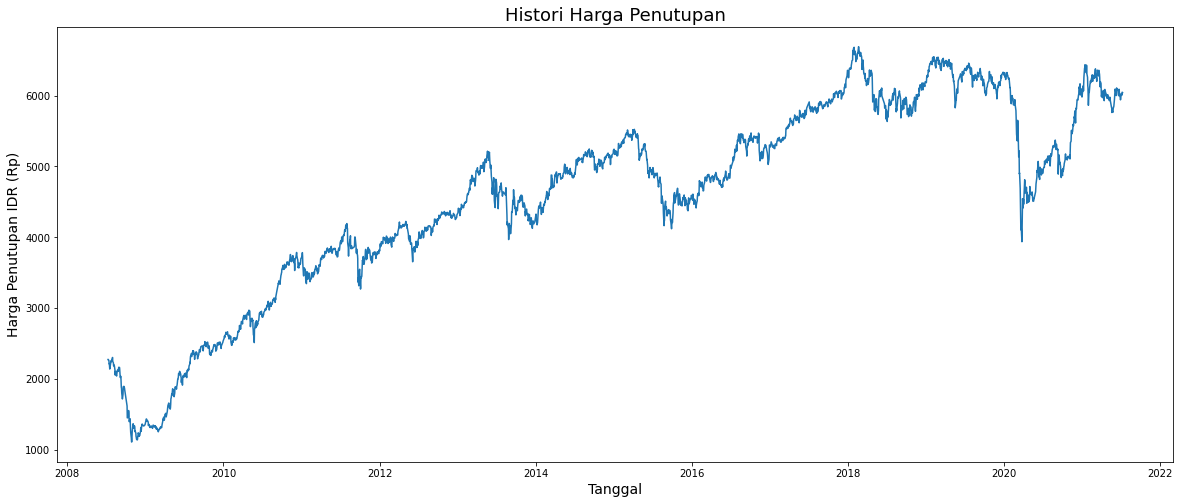

In [ ]:
# Visualisasi histori harga penutupan
plt.figure(figsize=(20,8))
plt.title('Histori Harga Penutupan',fontsize=18)
plt.plot(df['Close'])
plt.xlabel('Tanggal',fontsize=14)
plt.ylabel('Harga Penutupan IDR (Rp)',fontsize=14)
plt.show()

In [ ]:
# Melakukan penskalaan data menjadi nilai antara 0 dan 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
# Membuat skala untuk proses training dataset
train_data = scaled_data[0:training_data_len  , : ]

#Membagi data menjadi x_train dan y_train
x_train=[]
y_train = []
for i in range(50,len(train_data)):
    x_train.append(train_data[i-50:i,0])
    y_train.append(train_data[i,0])

In [ ]:
# Mengkonversi x_train dan y_train menjadi array numpy
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Cek apakah masih ada data yang null atau tidak
print("Apa masih ada data yang berisikan null?",np.isnan(x_train).any(), np.isnan(y_train).any())

Apa masih ada data yang berisikan null? False False


In [ ]:
# Melakukan reshape array menjadi array yang dapat dibaca model LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [ ]:
# Membuat model LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melakukan iterasi untuk melatih data dalam beberapa Epoch

In [ ]:
import tensorflow as tf
print("Mengecek ketersediaan GPU ...", tf.config.list_physical_devices('GPU'))

history = model.fit(x_train, y_train, epochs=50, batch_size=32)

Mengecek ketersediaan GPU ... [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/50
68/68 [==============================] - 10s 24ms/step - loss: 0.0108
Epoch 2/50
68/68 [==============================] - 2s 24ms/step - loss: 3.5730e-04
Epoch 3/50
68/68 [==============================] - 2s 24ms/step - loss: 3.4395e-04
Epoch 4/50
68/68 [==============================] - 2s 24ms/step - loss: 3.2390e-04
Epoch 5/50
68/68 [==============================] - 2s 24ms/step - loss: 3.3232e-04
Epoch 6/50
68/68 [==============================] - 2s 23ms/step - loss: 3.1662e-04
Epoch 7/50
68/68 [==============================] - 2s 24ms/step - loss: 3.4292e-04
Epoch 8/50
68/68 [==============================] - 2s 23ms/step - loss: 3.0660e-04
Epoch 9/50
68/68 [==============================] - 2s 23ms/step - loss: 2.9650e-04
Epoch 10/50
68/68 [==============================] - 2s 24ms/step - loss: 2.9631e-04
Epoch 11/50
68/68 [==============================] - 2s 24ms/step

# Melakukan Peramalan
Setelah data berhasil dilatih dengan model yang sudah dibuat, maka selanjutnya adalah proses peramalan

In [ ]:
#Menguji dataset

#Membuat x_test dan y_test dataset
test_data = scaled_data[training_data_len - 50: , : ]
x_test = []

# Mengambil semua baris dari index 2210 sampai terakhir atau 30% data testing
y_test =  dataset[training_data_len : , : ]
for i in range(50,len(test_data)):
    x_test.append(test_data[i-50:i,0])

In [ ]:
#Cek apakah masih ada data yang null atau tidak
print("Apa masih ada data yang berisikan null?",np.isnan(x_test).any(), np.isnan(y_test).any())

Apa masih ada data yang berisikan null? False False


In [ ]:
# Merubah nilai x_test menjadi array numpy
x_test = np.array(x_test)

In [ ]:
# Merubah data x_test dan y_test menjadi bentuk yang dapat digunakan untuk LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
# Mengambil nilai peramalan harga dari model
peramalan = model.predict(x_test)
peramalan = scaler.inverse_transform(peramalan) # mengembalikan nilai yang sudah diskalakan

In [ ]:
# Kalkulasi nilai dari RMSE
rmse=np.sqrt(np.mean(((peramalan- y_test)**2)))
print('Besarnya nilai error : {:.3f}'.format(rmse))

Besarnya nilai error : 63.672


In [ ]:
# Evaluasi model
score = model.evaluate(x_train, y_train)
print('Test loss: {:f}'.format(score))

68/68 [==============================] - 2s 9ms/step - loss: 7.4157e-05
Test loss: 0.000074


# Visualisasi data output

Grafik Peramalan dengan data training dan data testing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



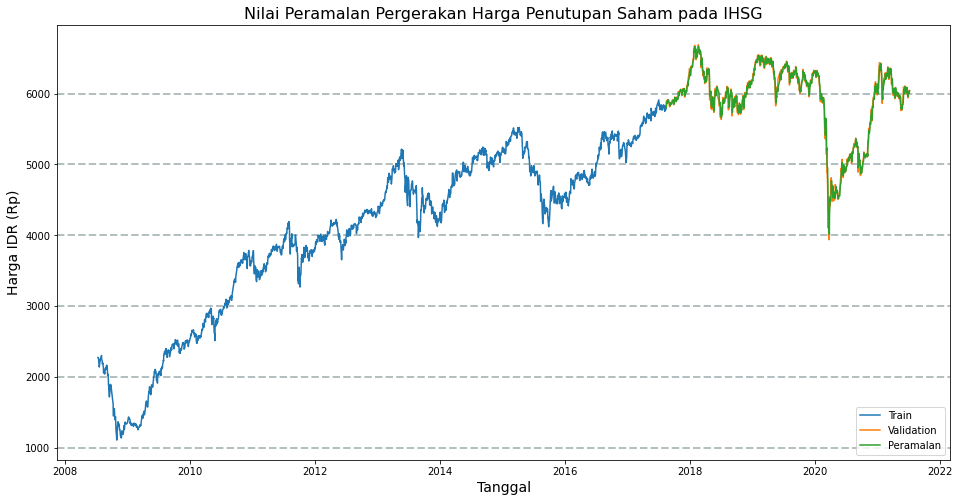

In [ ]:
# Membuat grafik data peramalan test
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Peramalan'] = peramalan

# Visualisasi data
plt.figure(figsize=(16,8))
plt.title('Nilai Peramalan Pergerakan Harga Penutupan Saham pada IHSG', fontsize=16)
plt.xlabel('Tanggal', fontsize=14)
plt.ylabel('Harga IDR (Rp)', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Peramalan']])
plt.legend(['Train', 'Validation', 'Peramalan'], loc='lower right')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

Grafik Peramalan dengan data testing (30% data (947 record)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



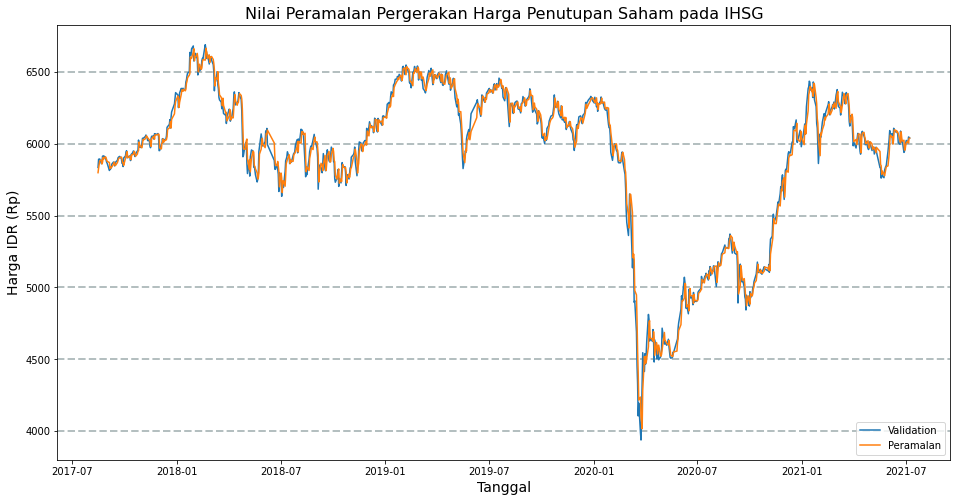

In [ ]:
# Membuat grafik data peramalan test
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Peramalan'] = peramalan

# Visualisasi data
plt.figure(figsize=(16,8))
plt.title('Nilai Peramalan Pergerakan Harga Penutupan Saham pada IHSG', fontsize=16)
plt.xlabel('Tanggal', fontsize=14)
plt.ylabel('Harga IDR (Rp)', fontsize=14)
plt.plot(valid[['Close', 'Peramalan']])
plt.legend(['Validation', 'Peramalan'], loc='lower right')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.show()

Menampilkan nilai asli dengan hasil peramalan

In [ ]:
# Menampilkan nilai asli dengan hasil peramalan
valid

,Close,Peramalan
Date,,
2017-08-15,5835.041016,5798.516113
2017-08-16,5891.949219,5830.413086
2017-08-18,5893.840820,5880.558105
2017-08-21,5861.003906,5886.439941
2017-08-22,5880.296875,5859.100586
...,...,...
2021-07-02,6023.007812,6005.893066
2021-07-05,6005.608887,6019.362793
2021-07-06,6047.110840,6004.538574


# Menyimpan hasil peramalan ke dalam csv

In [ ]:
# Menyimpan hasil data peramalan ke dalam bentuk Dataframe
pred_table = valid

# Melakukan Ekspor data menjadi bentuk CSV
export_csv = pred_table.to_csv (r'/content/Peramalan Close Price.csv', header=True)
print ("Dokumen CSV sudah tersimpan di direktori")

Dokumen CSV sudah tersimpan di direktori


File CSV dapat diunduh pada menu files di sidebar sebelah kiri